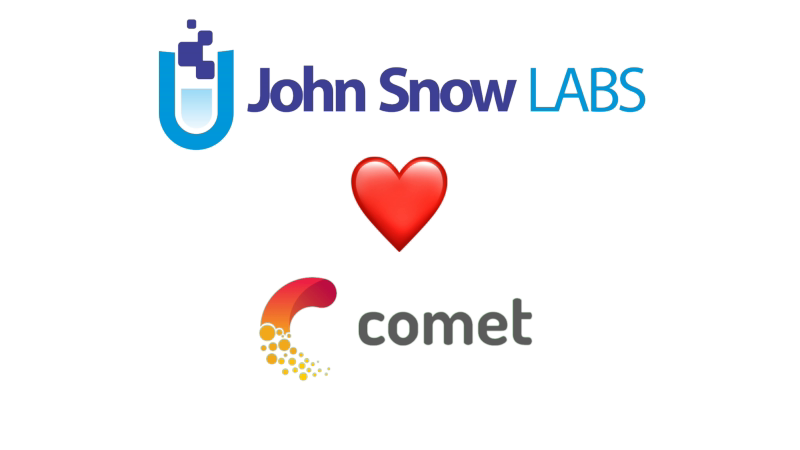

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp/blob/master/example/python/logging/Comet_SparkNLP_Integration.ipynb)

[Comet](https://www.comet.ml/site/) is an MLOps Platform that is designed to help Data Scientists and Teams build better models faster! Comet provides tooling to track, Explain, Manage, and Monitor your models in a single place! It works with Jupyter Notebooks and Scripts and most importantly it's 100% free!

Comet can be easily integrated into the Spark NLP workflow with a dedicated logging class CometLogger, to log training and evaluation metrics, pipeline parameters and NER visualization made with sparknlp-display.


# Installing SparkNLP

In [ ]:
# This is only to setup PySpark and Spark NLP on Colab
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

# Install Spark NLP Display for visualization
!pip install --ignore-installed spark-nlp-display

# Installing Comet
!pip install comet_ml --quiet

# Importing Dependencies and Starting Spark NLP

In [ ]:
# Import Spark NLP
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = sparknlp.start()

# Import Comet
import comet_ml
from sparknlp.logging.comet import CometLogger

# Initialize Comet

To run an online experiment, you will need an API key From Comet. See [Quick Start - Comet.ml](https://www.comet.ml/docs/quick-start/) for more information.

In [ ]:
comet_ml.init(project_name='sparknlp-test')

Please enter your Comet API key from https://www.comet.ml/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Comet API key is valid
COMET INFO: Comet API key saved in /root/.comet.config


# Logging from SparkNLP

## Logging Training Metrics

To log a Spark NLP annotator, it will need an “outputLogPath” parameter, as the CometLogger reads the log file generated during the training process.

In [ ]:
OUTPUT_LOG_PATH = './run'

### Create a Comet Logger

In [ ]:
logger = CometLogger()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/team-comet-ml/sparknlp-test/0c433df24b1b47038f0fc4b955ca9fba



### Download Data

In [ ]:
!curl -O 'https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/toxic_comments/toxic_train.snappy.parquet'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2702k  100 2702k    0     0  3081k      0 --:--:-- --:--:-- --:--:-- 3077k


### Create Dataset

In [ ]:
trainDataset = spark.read.parquet("toxic_train.snappy.parquet").repartition(120)

### Define SparkNLP Pipeline

In [ ]:
# Let's use shrink to remove new lines in the comments
document = (
    DocumentAssembler()
    .setInputCol("text")
    .setOutputCol("document")
    .setCleanupMode("shrink")
)

tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

# Here we use the state-of-the-art Universal Sentence Encoder model from TF Hub
use = (
    UniversalSentenceEncoder.pretrained()
    .setInputCols(["document"])
    .setOutputCol("sentence_embeddings")
)

# We will use MultiClassifierDL built by using Bidirectional GRU and CNNs inside TensorFlow that supports up to 100 classes
# We will use only 5 Epochs but feel free to increase it on your own dataset
multiClassifier = (
    MultiClassifierDLApproach()
    .setInputCols("sentence_embeddings")
    .setOutputCol("category")
    .setLabelColumn("labels")
    .setBatchSize(128)
    .setMaxEpochs(10)
    .setLr(1e-3)
    .setThreshold(0.5)
    .setShufflePerEpoch(False)
    .setEnableOutputLogs(True)
    .setOutputLogsPath(OUTPUT_LOG_PATH)
    .setValidationSplit(0.1)
)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


### Monitor the Model log file

SparkNLP will write the training metrics for this run to a log file. We're going to monitor this file for updates and log the entries to Comet as metrics. 

Before starting to fit our model, lets display Comet's Experiment View in the cell below so that we can view the metrics as they are reported. 

**Note:** It may take a few minutes before you see metrics displayed in the UI. 

In [ ]:
logger.experiment.display(tab='charts')

In [ ]:
logger.monitor(OUTPUT_LOG_PATH, multiClassifier)

### Run the training Pipeline

In [ ]:
pipeline = Pipeline(stages=[document, use, multiClassifier])
model = pipeline.fit(trainDataset)

## Logging Completed Runs

We can also log runs to Comet after training has finished. Let's take a look at the created log file from the earlier training run

In [ ]:
!ls ./run

In [ ]:
logger = CometLogger()
logger.log_completed_run('./run/MultiClassifierDLApproach_736adb7a5ea5.log')

In [ ]:
logger.experiment.display(tab='charts')

## Logging Evaluation Metrics

SparkNLP model predictions are easily convertible to Pandas Dataframes. We can then evaluate these predictions using libraries like `scikit-learn`. 

Here we demonstrate how to log metrics from a classification report to Comet

In [ ]:
logger = CometLogger()

In [ ]:
!curl -O 'https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/toxic_comments/toxic_test.snappy.parquet'

In [ ]:
testDataset = spark.read.parquet("/content/toxic_test.snappy.parquet").repartition(10)

In [ ]:
prediction = model.transform(testDataset)

In [ ]:
preds_df = prediction.select('labels', 'category.result').toPandas()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

mlb = MultiLabelBinarizer()

y_true = mlb.fit_transform(preds_df['labels'])
y_pred = mlb.fit_transform(preds_df['result'])

In [ ]:
report = classification_report(y_true, y_pred, output_dict=True)

In [ ]:
for key, value in report.items():
  logger.log_metrics(value, prefix=key)

In [ ]:
logger.experiment.display(tab='metrics')

## Logging Pipeline Parameters

You can also use the CometLogger to log SparkNLP Pipeline Parameters to Comet.

In [ ]:
logger = CometLogger()

#### Define a Pipeline with a Pretrained Model

In [ ]:
# If you change the model, re-run all the cells below
# Other applicable models: ner_dl, ner_dl_bert
MODEL_NAME = "onto_100"

documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# ner_dl and onto_100 model are trained with glove_100d, so the embeddings in
# the pipeline should match
if (MODEL_NAME == "ner_dl") or (MODEL_NAME == "onto_100"):
    embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
        .setInputCols(["document", 'token']) \
        .setOutputCol("embeddings")

# Bert model uses Bert embeddings
elif MODEL_NAME == "ner_dl_bert":
    embeddings = BertEmbeddings.pretrained(name='bert_base_cased', lang='en') \
        .setInputCols(['document', 'token']) \
        .setOutputCol('embeddings')

ner_model = NerDLModel.pretrained(MODEL_NAME, 'en') \
    .setInputCols(['document', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_converter = NerConverter() \
    .setInputCols(['document', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

nlp_pipeline = Pipeline(stages=[
    documentAssembler, 
    tokenizer,
    embeddings,
    ner_model,
    ner_converter
])

empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)

### Log PipelineModel Parameters

In [ ]:
logger.log_pipeline_parameters(pipeline_model)


### Logging Individual Parameters

In [ ]:
logger.log_parameters({"run-type": "training"})

Let's take a look at the logged Parameters. 

In [ ]:
logger.experiment.display(tab='parameters')
logger.end()

## Logging Visualizations

SparkNLP comes with a rich suite of visualization tools. Comet supports logging these visualizations so that they are readily available for analysis. 

In this section we will cover how to log SparkNLP visualzations to Comet

#### Define a Pipeline with a Pretrained Model

In [ ]:
# If you change the model, re-run all the cells below
# Other applicable models: ner_dl, ner_dl_bert
MODEL_NAME = "onto_100"

documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# ner_dl and onto_100 model are trained with glove_100d, so the embeddings in
# the pipeline should match
if (MODEL_NAME == "ner_dl") or (MODEL_NAME == "onto_100"):
    embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
        .setInputCols(["document", 'token']) \
        .setOutputCol("embeddings")

# Bert model uses Bert embeddings
elif MODEL_NAME == "ner_dl_bert":
    embeddings = BertEmbeddings.pretrained(name='bert_base_cased', lang='en') \
        .setInputCols(['document', 'token']) \
        .setOutputCol('embeddings')

ner_model = NerDLModel.pretrained(MODEL_NAME, 'en') \
    .setInputCols(['document', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_converter = NerConverter() \
    .setInputCols(['document', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

nlp_pipeline = Pipeline(stages=[
    documentAssembler, 
    tokenizer,
    embeddings,
    ner_model,
    ner_converter
])

empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)

### Run Inference with the NER Pipeline

In [ ]:
empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)

In [ ]:
import pandas as pd
text_list = [
    """William Henry Gates III (born October 28, 1955) is an American business magnate, software developer, investor, and philanthropist. He is best known as the co-founder of Microsoft Corporation. During his career at Microsoft, Gates held the positions of chairman, chief executive officer (CEO), president and chief software architect, while also being the largest individual shareholder until May 2014. He is one of the best-known entrepreneurs and pioneers of the microcomputer revolution of the 1970s and 1980s. Born and raised in Seattle, Washington, Gates co-founded Microsoft with childhood friend Paul Allen in 1975, in Albuquerque, New Mexico; it went on to become the world's largest personal computer software company. Gates led the company as chairman and CEO until stepping down as CEO in January 2000, but he remained chairman and became chief software architect. During the late 1990s, Gates had been criticized for his business tactics, which have been considered anti-competitive. This opinion has been upheld by numerous court rulings. In June 2006, Gates announced that he would be transitioning to a part-time role at Microsoft and full-time work at the Bill & Melinda Gates Foundation, the private charitable foundation that he and his wife, Melinda Gates, established in 2000.[9] He gradually transferred his duties to Ray Ozzie and Craig Mundie. He stepped down as chairman of Microsoft in February 2014 and assumed a new post as technology adviser to support the newly appointed CEO Satya Nadella.""",
    """The Mona Lisa is a 16th century oil painting created by Leonardo. It's held at the Louvre in Paris."""
]

df = spark.createDataFrame(pd.DataFrame({'text': text_list}))
results = pipeline_model.transform(df)

### Create and Log Visualizations

In [ ]:
from sparknlp_display import NerVisualizer

logger = CometLogger()

for idx, result in enumerate(results.collect()):
  viz = NerVisualizer().display(
    result=result,
    label_col='ner_chunk',
    document_col='document',
    return_html=True
  )
  logger.log_visualization(viz, name=f'viz-{idx}.html')

The HTML files from these files can be found in the "Assets & Artifacts" tab in the Experiment View.  

In [ ]:
logger.experiment.display(tab='assets')